## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)
pums_data['PINCP'], pincp_bins = pd.qcut(pums_data['PINCP'], q=10, labels=False, retbins=True)


# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
4,9.0,6,9.0,1,21.0,1,1.0,2.0,2,2.0,1,9.0,3,3.0,2.0,1.0
5,7.0,6,4.0,2,21.0,1,3.0,2.0,2,2.0,1,9.0,3,3.0,2.0,1.0
7,5.0,7,6.0,1,19.0,1,3.0,2.0,2,2.0,1,3.0,2,3.0,1.0,3.0
8,4.0,6,2.0,2,16.0,1,1.0,2.0,2,2.0,1,3.0,2,3.0,1.0,3.0
9,2.0,4,0.0,1,5.0,5,1.0,2.0,2,2.0,9,1.0,5,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,7.0,4,8.0,1,21.0,1,1.0,2.0,2,2.0,6,3.0,3,2.0,2.0,1.0
356010,8.0,3,9.0,1,18.0,1,1.0,2.0,2,2.0,1,6.0,4,2.0,3.0,1.0
356013,7.0,5,9.0,1,18.0,1,1.0,2.0,2,2.0,1,6.0,3,4.0,2.0,1.0
356014,7.0,5,6.0,2,19.0,1,1.0,2.0,2,2.0,1,6.0,3,4.0,2.0,1.0


In [3]:
HH_IDX = pums_data_p.shape[1] - 1  # Index of household variables start
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE
HH_VAR_NAMES = pums_data_h.columns  # Names of the hh variables

del pums_data_p
del pums_data_h

# Split categorical data into OHE vars, save num classes per variable, as well as numeric encodings per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
    del dummies
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [10, 9, 10, 2, 24, 5, 8, 2, 2, 2, 9, 10, 18, 7, 10, 3]


In [4]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
del ohe_var
MANIFEST_DIM = model_data_df.shape[1]
HH_IDX_MANIFEST = sum(CAT_LENGTHS[:HH_IDX])

# Add columns for original household variables; these will be used as conditionals
model_data_df = pd.concat([model_data_df, model_data_df.iloc[:,HH_IDX_MANIFEST:]], axis=1)

# Preview data that will be fed into model
model_data_df

,PINCP__0.0,PINCP__1.0,PINCP__2.0,PINCP__3.0,PINCP__4.0,PINCP__5.0,PINCP__6.0,PINCP__7.0,PINCP__8.0,PINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
356010,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
356013,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
356014,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.000007)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 1 samples


## Set Parameters and Define Model

In [6]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [4, 6, 8]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [313.08608531951904, 11.0505690574646, 0.02598349649036663, 0.006970305382407434, [512, 1000, 6, 64, 0.1]]
# [290.68157863616943, 6.595394611358643, 0.026173123522601732, 0.00692727365319053, [256, 1000, 6, 64, 0.1]]
# [99.60163021087646, 6.652237892150879, 0.028944710845045213, 0.0071278053533916155, [1024, 1000, 8, 16, 0.05]]

# Hyperparameters
BATCH_SIZE = 1024
EPOCHS = 1000
LATENT_DIM = 8
HIDDEN_DIM = 16
KL_WEIGHT = .05

## Training

In [7]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(loss_cat)

In [8]:
# # Load in the synthetic households
# synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
# synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# # Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
# synth_hh_df['HH_ID'] = synth_hh_df.index
# synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
# synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

def testModel(test_vae, latent_dim):
    # How many synthetic households to fill
    POP_SIZE = len(synth_hh_ohe_df)

    # Generate random normal sample to represent each latent variable, for each row (different person per row)
    np.random.seed(42)
    epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate persons; each person has unique latent input, plus shared hh inputs with their household
    results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])
    gen_time = time.time() - start_time

    # Convert the test results from logits to values
    synth_p_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
    synth_p_df.columns = VAR_NAMES

    # Assign the control variables from the synthetic households to individuals (replace what came from the model)
    for var in HH_VAR_NAMES[1:]:
        synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

    srmse_uni = SRMSE.calculateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))
    srmse_bi = SRMSE.calculateBivariateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [9]:
# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [10]:
# Train the model using single set of hyperparameters
start_time = time.time()
vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])
print(f"--- {time.time() - start_time} seconds ---")

Epoch 1/1000
1/1 [==============================] - 0s 249ms/step - tot_loss: 31.2309 - rec_loss: 31.1793 - kl_loss: 0.0516
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 32.3658 - rec_loss: 32.3188 - kl_loss: 0.0469
Epoch 3/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 31.1295 - rec_loss: 31.0846 - kl_loss: 0.0450
Epoch 4/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 31.2896 - rec_loss: 31.2451 - kl_loss: 0.0445
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 30.1150 - rec_loss: 30.0711 - kl_loss: 0.0439
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 30.5291 - rec_loss: 30.4852 - kl_loss: 0.0438
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 31.2602 - rec_loss: 31.2161 - kl_loss: 0.0441
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 29.2753 - rec_loss: 29.2303 - kl_loss: 0.0450
Epoch 9/1000
1/1 [====

1/1 [==============================] - 0s 1ms/step - tot_loss: 20.4587 - rec_loss: 20.2335 - kl_loss: 0.2252
Epoch 68/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 20.8726 - rec_loss: 20.6434 - kl_loss: 0.2292
Epoch 69/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 19.5776 - rec_loss: 19.3440 - kl_loss: 0.2336
Epoch 70/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 19.3537 - rec_loss: 19.1157 - kl_loss: 0.2381
Epoch 71/1000
1/1 [==============================] - 0s 72ms/step - tot_loss: 19.3212 - rec_loss: 19.0785 - kl_loss: 0.2427
Epoch 72/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 18.7617 - rec_loss: 18.5146 - kl_loss: 0.2471
Epoch 73/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 19.1088 - rec_loss: 18.8574 - kl_loss: 0.2514
Epoch 74/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 18.9729 - rec_loss: 18.7168 - kl_loss: 0.2561
Epoch 75/1000
1/1 [==========

1/1 [==============================] - 0s 1ms/step - tot_loss: 6.1382 - rec_loss: 5.7226 - kl_loss: 0.4156
Epoch 134/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 5.9361 - rec_loss: 5.5212 - kl_loss: 0.4149
Epoch 135/1000
1/1 [==============================] - 0s 975us/step - tot_loss: 5.8936 - rec_loss: 5.4796 - kl_loss: 0.4140
Epoch 136/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 5.7287 - rec_loss: 5.3157 - kl_loss: 0.4130
Epoch 137/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 5.6740 - rec_loss: 5.2621 - kl_loss: 0.4118
Epoch 138/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 5.6450 - rec_loss: 5.2345 - kl_loss: 0.4105
Epoch 139/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 5.6156 - rec_loss: 5.2063 - kl_loss: 0.4093
Epoch 140/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 5.2650 - rec_loss: 4.8567 - kl_loss: 0.4083
Epoch 141/1000
1/1 [=================

1/1 [==============================] - 0s 4ms/step - tot_loss: 2.0895 - rec_loss: 1.7798 - kl_loss: 0.3097
Epoch 201/1000
1/1 [==============================] - 0s 68ms/step - tot_loss: 2.0670 - rec_loss: 1.7591 - kl_loss: 0.3080
Epoch 202/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 2.1874 - rec_loss: 1.8811 - kl_loss: 0.3063
Epoch 203/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.9669 - rec_loss: 1.6620 - kl_loss: 0.3050
Epoch 204/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.9648 - rec_loss: 1.6613 - kl_loss: 0.3035
Epoch 205/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 2.0587 - rec_loss: 1.7567 - kl_loss: 0.3020
Epoch 206/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 2.0368 - rec_loss: 1.7362 - kl_loss: 0.3006
Epoch 207/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.9022 - rec_loss: 1.6028 - kl_loss: 0.2994
Epoch 208/1000
1/1 [==================

1/1 [==============================] - 0s 1ms/step - tot_loss: 1.0628 - rec_loss: 0.8332 - kl_loss: 0.2296
Epoch 268/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.1904 - rec_loss: 0.9616 - kl_loss: 0.2289
Epoch 269/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.1522 - rec_loss: 0.9240 - kl_loss: 0.2283
Epoch 270/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.0701 - rec_loss: 0.8424 - kl_loss: 0.2277
Epoch 271/1000
1/1 [==============================] - 0s 80ms/step - tot_loss: 1.0943 - rec_loss: 0.8673 - kl_loss: 0.2270
Epoch 272/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.0584 - rec_loss: 0.8322 - kl_loss: 0.2263
Epoch 273/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.0385 - rec_loss: 0.8131 - kl_loss: 0.2254
Epoch 274/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.0183 - rec_loss: 0.7939 - kl_loss: 0.2243
Epoch 275/1000
1/1 [==================

1/1 [==============================] - 0s 1ms/step - tot_loss: 0.6844 - rec_loss: 0.5317 - kl_loss: 0.1527
Epoch 335/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.7094 - rec_loss: 0.5577 - kl_loss: 0.1517
Epoch 336/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.7280 - rec_loss: 0.5773 - kl_loss: 0.1507
Epoch 337/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.6962 - rec_loss: 0.5464 - kl_loss: 0.1497
Epoch 338/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.7177 - rec_loss: 0.5689 - kl_loss: 0.1487
Epoch 339/1000
1/1 [==============================] - 0s 9ms/step - tot_loss: 0.7784 - rec_loss: 0.6306 - kl_loss: 0.1478
Epoch 340/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.6697 - rec_loss: 0.5226 - kl_loss: 0.1471
Epoch 341/1000
1/1 [==============================] - 0s 79ms/step - tot_loss: 0.6562 - rec_loss: 0.5100 - kl_loss: 0.1462
Epoch 342/1000
1/1 [==================

1/1 [==============================] - 0s 79ms/step - tot_loss: 0.5326 - rec_loss: 0.4119 - kl_loss: 0.1207
Epoch 402/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 0.4924 - rec_loss: 0.3725 - kl_loss: 0.1199
Epoch 403/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.6692 - rec_loss: 0.5502 - kl_loss: 0.1190
Epoch 404/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.4859 - rec_loss: 0.3672 - kl_loss: 0.1187
Epoch 405/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.4827 - rec_loss: 0.3644 - kl_loss: 0.1183
Epoch 406/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.5193 - rec_loss: 0.4017 - kl_loss: 0.1177
Epoch 407/1000
1/1 [==============================] - 0s 7ms/step - tot_loss: 0.4645 - rec_loss: 0.3474 - kl_loss: 0.1171
Epoch 408/1000
1/1 [==============================] - 0s 7ms/step - tot_loss: 0.4806 - rec_loss: 0.3642 - kl_loss: 0.1163
Epoch 409/1000
1/1 [==================

1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3632 - rec_loss: 0.2901 - kl_loss: 0.0731
Epoch 468/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.3469 - rec_loss: 0.2749 - kl_loss: 0.0720
Epoch 469/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.3835 - rec_loss: 0.3126 - kl_loss: 0.0709
Epoch 470/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 0.3563 - rec_loss: 0.2864 - kl_loss: 0.0699
Epoch 471/1000
1/1 [==============================] - 0s 74ms/step - tot_loss: 0.3369 - rec_loss: 0.2680 - kl_loss: 0.0689
Epoch 472/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3458 - rec_loss: 0.2780 - kl_loss: 0.0678
Epoch 473/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.4231 - rec_loss: 0.3564 - kl_loss: 0.0667
Epoch 474/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3382 - rec_loss: 0.2723 - kl_loss: 0.0659
Epoch 475/1000
1/1 [==================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.3066 - rec_loss: 0.2381 - kl_loss: 0.0685
Epoch 535/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2788 - rec_loss: 0.2112 - kl_loss: 0.0676
Epoch 536/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2828 - rec_loss: 0.2161 - kl_loss: 0.0667
Epoch 537/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3268 - rec_loss: 0.2612 - kl_loss: 0.0656
Epoch 538/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.3734 - rec_loss: 0.3087 - kl_loss: 0.0647
Epoch 539/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2718 - rec_loss: 0.2078 - kl_loss: 0.0641
Epoch 540/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.3141 - rec_loss: 0.2508 - kl_loss: 0.0633
Epoch 541/1000
1/1 [==============================] - 0s 78ms/step - tot_loss: 0.2760 - rec_loss: 0.2133 - kl_loss: 0.0627
Epoch 542/1000
1/1 [==================

1/1 [==============================] - 0s 73ms/step - tot_loss: 0.2688 - rec_loss: 0.1997 - kl_loss: 0.0690
Epoch 602/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2461 - rec_loss: 0.1782 - kl_loss: 0.0679
Epoch 603/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2365 - rec_loss: 0.1697 - kl_loss: 0.0667
Epoch 604/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2980 - rec_loss: 0.2325 - kl_loss: 0.0655
Epoch 605/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2364 - rec_loss: 0.1719 - kl_loss: 0.0646
Epoch 606/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.2276 - rec_loss: 0.1640 - kl_loss: 0.0636
Epoch 607/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.2657 - rec_loss: 0.2031 - kl_loss: 0.0625
Epoch 608/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2310 - rec_loss: 0.1694 - kl_loss: 0.0616
Epoch 609/1000
1/1 [==================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2064 - rec_loss: 0.1463 - kl_loss: 0.0601
Epoch 669/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2245 - rec_loss: 0.1636 - kl_loss: 0.0609
Epoch 670/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2045 - rec_loss: 0.1430 - kl_loss: 0.0615
Epoch 671/1000
1/1 [==============================] - 0s 142ms/step - tot_loss: 0.2111 - rec_loss: 0.1492 - kl_loss: 0.0619
Epoch 672/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.2192 - rec_loss: 0.1571 - kl_loss: 0.0621
Epoch 673/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.1982 - rec_loss: 0.1360 - kl_loss: 0.0622
Epoch 674/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.2005 - rec_loss: 0.1384 - kl_loss: 0.0621
Epoch 675/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1996 - rec_loss: 0.1378 - kl_loss: 0.0618
Epoch 676/1000
1/1 [=================

1/1 [==============================] - 0s 3ms/step - tot_loss: 0.1501 - rec_loss: 0.1194 - kl_loss: 0.0307
Epoch 736/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 0.1473 - rec_loss: 0.1168 - kl_loss: 0.0304
Epoch 737/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.1615 - rec_loss: 0.1313 - kl_loss: 0.0301
Epoch 738/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.2284 - rec_loss: 0.1986 - kl_loss: 0.0298
Epoch 739/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.1486 - rec_loss: 0.1188 - kl_loss: 0.0298
Epoch 740/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1824 - rec_loss: 0.1527 - kl_loss: 0.0297
Epoch 741/1000
1/1 [==============================] - 0s 87ms/step - tot_loss: 0.1876 - rec_loss: 0.1580 - kl_loss: 0.0296
Epoch 742/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.3087 - rec_loss: 0.2790 - kl_loss: 0.0297
Epoch 743/1000
1/1 [==================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1677 - rec_loss: 0.1377 - kl_loss: 0.0300
Epoch 803/1000
1/1 [==============================] - 0s 5ms/step - tot_loss: 0.1297 - rec_loss: 0.1000 - kl_loss: 0.0297
Epoch 804/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.1352 - rec_loss: 0.1059 - kl_loss: 0.0293
Epoch 805/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1377 - rec_loss: 0.1088 - kl_loss: 0.0288
Epoch 806/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1263 - rec_loss: 0.0979 - kl_loss: 0.0284
Epoch 807/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1247 - rec_loss: 0.0969 - kl_loss: 0.0278
Epoch 808/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1244 - rec_loss: 0.0971 - kl_loss: 0.0273
Epoch 809/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1340 - rec_loss: 0.1073 - kl_loss: 0.0267
Epoch 810/1000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1595 - rec_loss: 0.0859 - kl_loss: 0.0736
Epoch 870/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1629 - rec_loss: 0.0907 - kl_loss: 0.0722
Epoch 871/1000
1/1 [==============================] - 0s 129ms/step - tot_loss: 0.1585 - rec_loss: 0.0877 - kl_loss: 0.0708
Epoch 872/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1741 - rec_loss: 0.1046 - kl_loss: 0.0694
Epoch 873/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1530 - rec_loss: 0.0849 - kl_loss: 0.0681
Epoch 874/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1542 - rec_loss: 0.0874 - kl_loss: 0.0668
Epoch 875/1000
1/1 [==============================] - 0s 5ms/step - tot_loss: 0.1553 - rec_loss: 0.0898 - kl_loss: 0.0655
Epoch 876/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1480 - rec_loss: 0.0839 - kl_loss: 0.0641
Epoch 877/1000
1/1 [=================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.0999 - rec_loss: 0.0799 - kl_loss: 0.0201
Epoch 937/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1293 - rec_loss: 0.1092 - kl_loss: 0.0201
Epoch 938/1000
1/1 [==============================] - 0s 16ms/step - tot_loss: 0.0962 - rec_loss: 0.0761 - kl_loss: 0.0201
Epoch 939/1000
1/1 [==============================] - 0s 12ms/step - tot_loss: 0.1037 - rec_loss: 0.0836 - kl_loss: 0.0201
Epoch 940/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1125 - rec_loss: 0.0925 - kl_loss: 0.0200
Epoch 941/1000
1/1 [==============================] - 0s 401ms/step - tot_loss: 0.1060 - rec_loss: 0.0861 - kl_loss: 0.0200
Epoch 942/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.1250 - rec_loss: 0.1051 - kl_loss: 0.0199
Epoch 943/1000
1/1 [==============================] - 0s 7ms/step - tot_loss: 0.0961 - rec_loss: 0.0763 - kl_loss: 0.0198
Epoch 944/1000
1/1 [===============

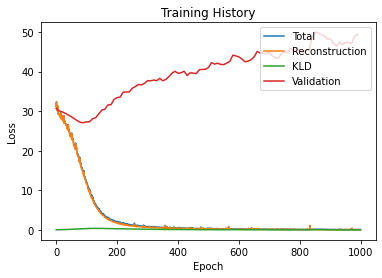

In [11]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Total","Reconstruction","KLD","Validation"], loc="upper right")
plt.show()

## Testing

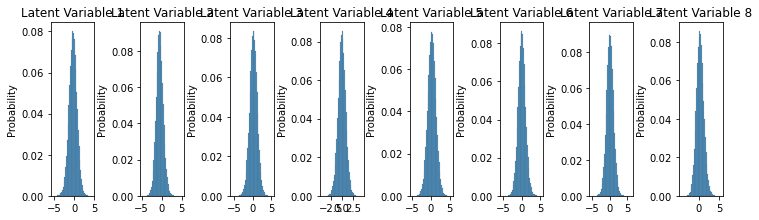

In [12]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1}")

In [13]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 49.527870178222656


In [14]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

## Generating Synthetic Population

In [15]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# How many variables represent each household
HH_DIM = 5

In [16]:
# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

# How many synthetic households to fill
POP_SIZE = len(synth_hh_ohe_df)
print(POP_SIZE)

469323


In [17]:
# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Load the most recently trained model
# vae = keras.models.load_model('person_synthesizer')

start_time = time.time()

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])

print(f"--- {time.time() - start_time} seconds ---")

del epsilon

# Convert the test results from logits to values
synth_p_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
synth_p_df.columns = VAR_NAMES

# Assign the control variables from the synthetic households to individuals (replace what came from the model)
for var in HH_VAR_NAMES[1:]:
    synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

# Save the synthesized persons
synth_p_df.to_csv('data/synthetic_populations/wa_persons_1.csv', index=False)

--- 15.963788747787476 seconds ---


<ipython-input-18-370640e01e01>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=40)


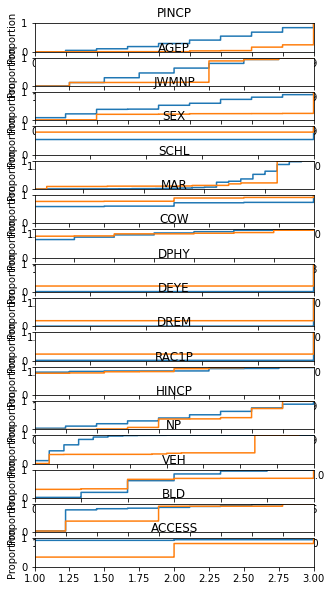

In [18]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=40)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_p_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)

In [19]:
testModel(test_vae=vae, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

Univariate (marginal) SRMSE: 0.2310774696219162
Bivariate (joint) SRMSE: 0.03513305237138038


(18.645195484161377, 0.2310774696219162, 0.03513305237138038)